# Machine Learning for disease diagnosis using omics data

### Discussion Agenda 21/06/21:

1. Review of initial results
2. Specific questions on methodlogy
    - I have z-scored the whole column together, rather than the classes separately as John did in poster work. Thoughts?
    - Initial results (if correct) suggest it is farily simple to discriminate sepsis from non-sepsis with this genomic dataset. Can this be right? If so, has implications for where we take the work next.
    - Feedback on feature selection approaches
    - Any guidence on potential deep neural network based approaches from the lit search
3. Discuss and agree next steps in the light of the initial results
4. Agree the right format for future bi-weekly updates



### Aims and Objectives

The aim of this project is to develop a machine learning system capable of diagnosing neo-natal sepsis based on genomic and clinical patient data. The system will successfully perform a binary classification of examples as either infected (i.e. have sepsis) and not infected. Initial objectives:
- Review existing literature and techniques for disease diagnosis using machine learning with omics data
- Test and compare the effectiveness of alternative strategies for dimensionality reduction - the dataset contains 63 samples and over 48,000 features. Candidate techniques include:
    - Univariate statistical tests on each feature - e.g. Pairwise t-tests/ mann-whitney tests / mutual information on each individual features, and selecting k best features based on scores.
    - L1 regularisation to downweight irrelevant features in linear model (e.g. in logistic regression/ linear svm)
    - Recursive feature elimination (e.g. in SVM, Tree based models)
- Test alternative classifiers and compare results, including ensemble models. The choice of classifiers will be directed by the high dimensionality, low sample size (HDLSS) nature of this problem. Candidate techniques include:
    - Logistic regression - L1 regularised
    - Support Vector Machines, with recursive feature elimination
    - Ensemble decision tree based methods (e.g. random forest), again with recursive feature elimination
    - Deep Neural Network based methods to capture non-linear relationships that are designed to work with with high dimenional, low sample size data - combined dimentionality reduction and classification techniques such as FsNet and Deep Neural Pursuit (see lit review 5 and 6)
- Identify the specific biomarkers (genes) and clinical data points that show the greatest importance in successfully discrimnating sepsis.

### Background / Literature Review (at 16/6/21)

The following papers provide relevant starting points for investigation:

1. [Gene selection for cancer classification using SVMs, Guyon et al. 2001](https://link.springer.com/article/10.1023/A:1012487302797)
2. [Applications of Support Vector Machine (SVM) Learning in Cancer Genomics, Huang et al. 2018](https://pubmed.ncbi.nlm.nih.gov/29275361)
3. [Machine learning and complex biological data, Jackson et al. 2019](https://link.springer.com/article/10.1186/s13059-019-1689-0)
4. [Machine learning algorithm validation with a limited sample size, Vabalas et al. 2019](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0224365)
5. [FsNet: Feature Selection Network on High-dimensional Biological Data, Singh et al. 2020](https://arxiv.org/abs/2001.08322)
6. [Deep Neural Networks for High Dimension, Low Sample Size Data, Liu et al. 2017](https://www.semanticscholar.org/paper/Deep-Neural-Networks-for-High-Dimension%2C-Low-Sample-Liu-Wei/76f755fed7bf1cea8dad35c16bf518eab158c13e?p2df)

### Summary of Methodology and Initial Results

This file and raw data in github repo here: 

**1. Data pre-processing (genomic data only to date)**

- Neonatal_dataset saved in CSV format.
- Data de-duplicated based on the feature 'Probe_Id' based on advice from project sepsis team. 1 duplicate row identified and eliminated
- Standardisation- NaN values replaced with mean for the feature. Data then standardised (z-scored) to enable use of regression coefficients to determine feature importance, application of L1 regularlisation and use of distance based techniques such as SVM. (Implication is that NaN values standardised to zero).
- Train/test split of 60% train / 40% test giving 37 training examples and 26 test examples. Chose 60/40 to ensure sufficient examples in test to validate the results. Decided against a separate validation set initially given low sample size. k-fold cross validation of train used used for tuning where appropriate.

**2. Logistic regression**

- Logistic regression chosen as a baseline. Method used by John in sepsis vs. TB poster.
- Logistic regression classifier with L1 regularisation. C search using 5-fold cross validation over search space of 20 values
- Optimum value of C = 0.23
- 23 features gave non-zero coefficients in the resulting model
- Performance scores below. 2 false positives on test.

**3. SVM with recursive feature elimination**

- SVM with recursive feature elimination has been demonstrated as an effective approach to classification with omics data (see ref 1., Guyon et al. 2001 above)
- Performing RFE on all 48,000 features computationally expensive, therefore initially performed feature selection to reduce to 500 features based on univariate tests using mutual information gain (entropy) and retaining the highest scoring features.
- Recursive feature elimination (RFE) used to select 10 best features (10 is arbitrary and requires investigation).

**4. Random Forest**

- Random forest classifier tested using the reduced 500 feature train set. Used default parameters initially.
- RFE used to select 10 best features.

**5. Initial Results**

Model Evaluation:

| ML Method           | Precision | Recall | AUC  |
| :-                  | :-:       | :-:    |:-:   |
| Logistic Regression | 0.89      | 1.0    | 1.0  |
| SVM - RFE           | 1.0       | 0.94   | 1.0  |
| Random Forest - RFE | 0.94      | 0.94   | 0.96 |

Genes (features) identified by at least two methods. These were either in the 23 features with non-zero regression coeficients and the top 10 of SVM or RF, or in top 10 of both SVM and RF:

| Probe_Id     | ILMN_Gene |
| :-           | :- |
| ILMN_1733276 | CYSLTR1 |
| ILMN_2087989 | ZFAND1 |
| ILMN_1715669 | TP53I11 |
| ILMN_2400183 | DPH5 |
| ILMN_1804148 | TMED4 

This basket of 5 genes only was used to train a logistic regression classifier with the following results. This indicates that this group of genes alone may be a reasonable discriminator of sepsis vs. no-sepsis.

Recall:  1.0
Precision:  0.94
AUC:   0.94

**6. Potential Next Steps**

- Experiment with / improve the feature selection methods to ensure they are robust.
- Build feature selection into pipelines along with models
- Hyper parameter tune and optimise models
- Run svm and random forest models with recursive feature selection / sequential feature selection without univariate feature selection first - requires time to run or running on a server (tbd)
- Identify single genes, pairs and triples that discriminate the classes.
- Build emsemble of the various classifiers to improve performance
- Integrate clinical data - requires some pre-processing
- Gather additional data - sepsis or otherwise to expand the scope of the work
- Experiment with deep learning based methods from lit search


# Code:

In [839]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
np.random.seed(1)
#os.getcwd()

### Data Import and Reformatting

In [840]:
# import and check data

raw_data = pd.read_csv('genomic_data.csv')
print('The number of columns is:  '+str(len(raw_data.columns)))
print('The number of row is:  '+str(len(raw_data)))

The number of columns is:  93
The number of row is:  48804


In [760]:
# Eliminate duplicate genes. Testing on various columns, NaN values excluded before looking for duplicates.

dup_column = ['NuID', 'Search_Key', 'ILMN_Gene', 'RefSeq_ID', 'Entrez_Gene_ID', 'Probe_Id']
for column in dup_column:
    data = raw_data.dropna(subset=[column])
    dup_list = []
    for index, value in data.duplicated(subset=[column]).items():
        if value == True:
            dup_list.append(index)
    print(f"# duplicate rows based on {column}:   "+str(len(dup_list)))

# duplicate rows based on NuID:   0
# duplicate rows based on Search_Key:   4671
# duplicate rows based on ILMN_Gene:   11000
# duplicate rows based on RefSeq_ID:   5742
# duplicate rows based on Entrez_Gene_ID:   10897
# duplicate rows based on Probe_Id:   1


In [761]:
# reformat data, drop duplicates, transpose, index on probe_id, drop columns with all NaN, drop Fold change

labels = []
for item in df.index:
    if 'Con' in item:
        labels.append(0)
    else:
        labels.append(1)
labels = np.asarray(labels)

gene_df = raw_data.iloc[:, 0:29]
df = raw_data.iloc[:, np.r_[14, 29:93]].drop_duplicates(subset=['Probe_Id'])
df = df.transpose()
df = df.rename(columns=df.iloc[0]).drop(df.index[0])
df = df.drop(['Fold change'], axis=0)
df = df.dropna(axis=1, how='all')
print('Features:  '+str(len(df.columns)))
print('Examples:  '+str(len(df)))
df.head()

Features:  48802
Examples:  63


,ILMN_2227757,ILMN_1683690,ILMN_1710146,ILMN_1822171,ILMN_1748473,ILMN_1822843,ILMN_1710170,ILMN_1704497,ILMN_1847638,ILMN_1772260,...,ILMN_1712859,ILMN_1747129,ILMN_1813344,ILMN_2292576,ILMN_1793445,ILMN_2065273,ILMN_1800873,ILMN_1666642,ILMN_1908209,ILMN_1670343
Con_001,7.0713,7.0252,7.0713,7.0713,12.8555,7.0395,7.0252,7.0252,6.9692,7.1443,...,6.9278,7.0713,7.6728,7.0545,7.0103,7.0252,7.2258,7.3808,7.2626,6.9828
Con_017,7.0033,7.0436,7.0832,7.1232,12.5604,7.1232,7.0301,7.1486,6.9203,7.1865,...,7.0436,7.0164,8.1798,6.9896,6.9896,7.0963,7.0577,6.9492,7.0164,7.0301
Con_021,7.0907,7.0323,7.097,7.0824,12.5437,7.0583,7.0739,6.9975,6.9975,7.0405,...,7.097,7.0158,7.8981,7.0158,7.1521,7.0655,7.0824,6.9975,7.097,6.9892
Con_022b,7.0327,7.024,7.0419,7.024,12.0483,7.0766,7.0598,7.1015,6.9954,7.0055,...,7.1564,7.167,7.9036,6.9031,7.0598,6.9863,7.1625,7.1378,7.024,7.0327
Con_028,7.0057,6.9538,7.0308,7.0831,12.6549,6.9538,6.9538,7.1371,7.1512,7.264,...,7.0577,7.0057,8.2019,7.0308,7.0702,6.9799,7.0963,7.1512,7.2064,7.0186


### Pre-Processing

1. **Standardisation** - Data standardised (i.e. z-scored) for the following reasons:
- L1 regularisation penalties in logistic regressions assumes data centred at zero and on the same scale
- Distance based ML models such as SVM require and assume standardised data, otherwise variables on larger scales disproportionally impact the model
- Am using the output coeffiecients from logistic regression as a crude measure of feature importance, and so in order to compare coefficients as a measure of relative importance, variables must be standardised

2. **Train, test, split:** 60% train / 40% test


In [762]:
# function for standardising, train, test split

def standardise(examples):
    imputer = SimpleImputer(strategy='mean')
    examples_imputed = imputer.fit_transform(examples)
    scaler = StandardScaler()
    examples_scaled = scaler.fit_transform(examples_imputed)
    return examples_scaled

# train and test sets

X = standardise(df)
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.4, random_state=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(37, 48802)
(37,)
(26, 48802)
(26,)


### Classifier 1: Logistic Regression

- L1 regularised logistic regression. L1 used given we know that a large number of feature are irrelevant, hence L1 / Lasso regularisation acts as form of feature selection. L1 required the liblinear solver.
- Performed with stratified k-fold cross validation (5 folds) on the regularisation parameter C

Optimum L1 regularisation parameter: [0.23357215]
Accuracy:  0.92
Recall:  1.0
Precision:  0.89
AUC:   1.0


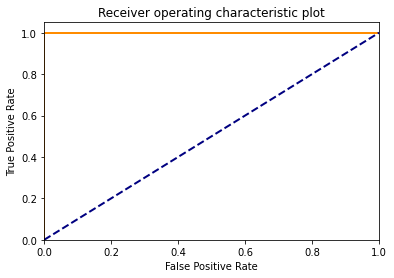

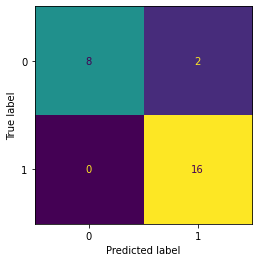

In [794]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# train
log_reg_cv = LogisticRegressionCV(Cs=20, penalty='l1', solver="liblinear", random_state=1)
log_reg_cv.fit(X_train, y_train)
print('Optimum L1 regularisation parameter: '+str(log_reg_cv.C_))

# predict
y_pred_lr = log_reg_cv.predict(X_test)
y_pred_probab_lr = log_reg_cv.predict_proba(X_test)

# evaluate
model_analysis(log_reg_cv, X_test, y_pred_lr, y_pred_probab_lr, y_test)

### Classifier 2: SVM

1. Initial feature selection using kbest feature selection and mutual information gain
2. Further feature selection using recursive feature selection (RFE) to get down the the best performing set of features on linear svm

References:
https://machinelearningmastery.com/rfe-feature-selection-in-python/
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [765]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from numpy.random import uniform
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.feature_selection import SelectKBest


In [766]:
# Initial crude feature selection

num_features = 500
fs=SelectKBest(mutual_info_classif, k=num_features).fit(X_train, y_train)
X_train_red = fs.transform(X_train)
X_test_red = fs.transform(X_test)

Accuracy:  0.96
Recall:  0.94
Precision:  1.0
AUC:   1.0


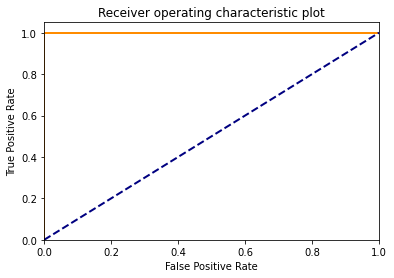

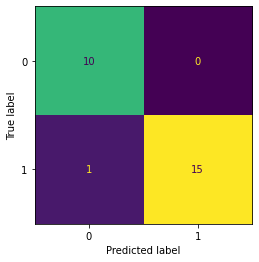

In [793]:
# Linear SVM classifier with all features

# train
svm_clf=SVC(kernel="linear", probability=True, random_state=1)
svm_clf.fit(X_train_red, y_train)

# predict
y_pred_svm = svm_clf.predict(X_test_red)
y_pred_probab_svm = svm_clf.predict_proba(X_test_red)

# evaluate
model_analysis(svm_clf, X_test_red, y_pred_svm, y_pred_probab_svm, y_test)

Accuracy:  0.96
Recall:  0.94
Precision:  1.0
AUC:   1.0


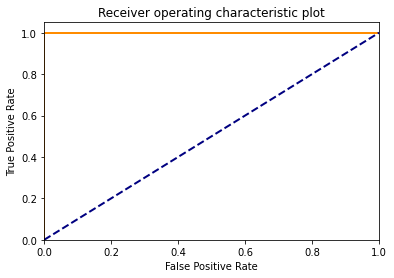

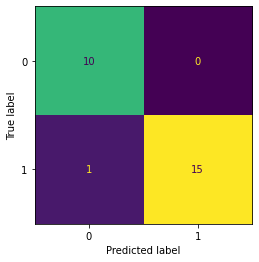

In [796]:
# Linear SVM with Recursive Feature Elimination

# train
svm_clf = SVC(kernel="linear", probability=True, random_state=1, C=1.0)
svm_selector = RFE(svm_clf, n_features_to_select=10, step=1)
svm_selector = svm_selector.fit(X_train_red, y_train)

# predict
y_pred_svmrfe = svm_selector.predict(X_test_red)
y_pred_probab_svmrfe = svm_selector.predict_proba(X_test_red)

# evaluate
model_analysis(svm_selector, X_test_red, y_pred_svmrfe, y_pred_probab_svmrfe, y_test)

### Classifier 3: Random Forest

Accuracy:  0.92
Recall:  0.94
Precision:  0.94
AUC:   0.96


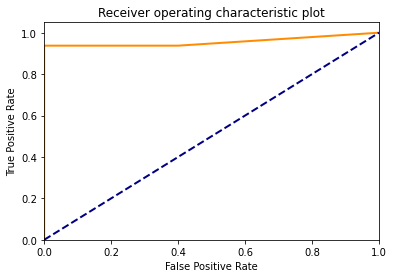

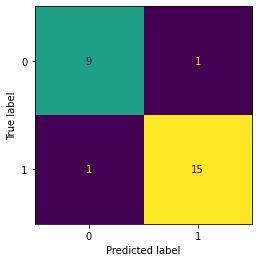

In [795]:
# Random Forest with Recursive Feature Elimination

from sklearn.ensemble import RandomForestClassifier

# train
rf_clf = RandomForestClassifier(random_state=1)
rf_selector = RFE(rf_clf, n_features_to_select=10, step=1)
rf_selector = rf_selector.fit(X_train_red, y_train)

# predict
y_pred_rf = rf_selector.predict(X_test_red)
y_pred_probab_rf = rf_selector.predict_proba(X_test_red)

# evaluate
model_analysis(rf_selector, X_test_red, y_pred_rf, y_pred_probab_rf, y_test)

In [791]:
def model_analysis(fitted_model, X_test, y_pred_classes, y_pred_probabilities, y_true_classes):
    print('Accuracy:  '+str(round(accuracy_score(y_true_classes, y_pred_classes),2)))
    print('Recall:  '+str(round(recall_score(y_true_classes, y_pred_classes),2)))
    print('Precision:  '+str(round(precision_score(y_true_classes, y_pred_classes),2))) 
    print('AUC:   '+str(round(roc_auc_score(y_true_classes, y_pred_probabilities[:, 1]),2)))
    build_roc_auc(y_pred_probabilities, y_true_classes)
    plot_confusion_matrix(fitted_model, X_test, y_true_classes, colorbar=False)

In [716]:
# function for building the ROC curve


import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp

def build_roc_auc(y_preds, y_test): #model, X_train, X_test, y_train, y_test):
    '''
    INPUT:
    model - an sklearn instantiated model
    X_train - the training data
    y_train - the training response values
    X_test - the test data
    y_test - the test response values
    
    OUTPUT:
    auc - returns auc as a float
    prints the roc curve
    '''
    
    #y_preds = model.fit(X_train, y_train).predict_proba(X_test)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(y_test)):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_preds[:, 1])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_preds[:, 1].ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(fpr[2], tpr[2], color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic plot')
    plt.show()
    
    return roc_auc_score(y_test, np.round(y_preds[:, 1]))

# https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

### Gene Identification

Using most important features output to identify the genes used by the classifiers

In [809]:
# the 500 features selected by feature selection given by

gene_codes = df.columns
kbest_genes = fs.get_support()
gene_list = list(zip(gene_codes, kbest_genes))

gene_codes_reduced = []
for gene in gene_list:
    if gene[1] == True:
        gene_codes_reduced.append(gene[0])

# the features retained by RFE given by:

models = [svm_selector, rf_selector]

model_genes_list = []
for model in models:
    selected_genes_mask = model.support_
    selected_genes = []
    for gene in list(zip(gene_codes_reduced, selected_genes_mask)):
        if gene[1] == True:
            selected_genes.append(gene[0]) 
    model_genes_list.append(selected_genes)

model_genes_list
            
#print(gene_df[gene_df['Probe_Id'].isin(selected_genes)].iloc[:, np.r_[14, 5]])

[['ILMN_1733276',
  'ILMN_1769633',
  'ILMN_2110829',
  'ILMN_2087989',
  'ILMN_1715669',
  'ILMN_1675937',
  'ILMN_2400183',
  'ILMN_1679826',
  'ILMN_1804148',
  'ILMN_1653200'],
 ['ILMN_1730082',
  'ILMN_1715669',
  'ILMN_2079386',
  'ILMN_1784523',
  'ILMN_1802251',
  'ILMN_2337974',
  'ILMN_2376205',
  'ILMN_1719205',
  'ILMN_1666399',
  'ILMN_1687738']]

23


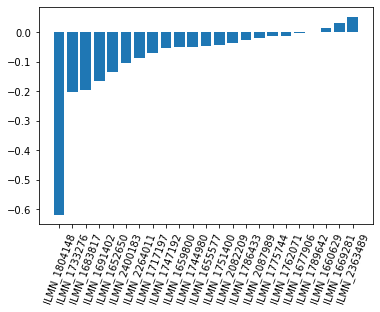

In [817]:
# get proxy for feature importance

gene_codes = df.columns
gene_coefs = list(zip(gene_codes, log_reg_cv.coef_[0]))

selected_genes_lr = []
for gene in gene_coefs:
    if gene[1] != 0:
        selected_genes_lr.append(gene)

selected_genes_sorted = sorted(selected_genes_lr, key = lambda x: x[1])
print(len(selected_genes_sorted))

gene_ids_lr = []
for gene in selected_genes_sorted:
    gene_ids_lr.append(gene[0])

model_genes_list.append(gene_ids_lr)

from matplotlib import pyplot

pyplot.bar(range(len(selected_genes_sorted)), [val[1] for val in selected_genes_sorted])
pyplot.xticks(range(len(selected_genes_sorted)), [val[0] for val in selected_genes_sorted])
pyplot.xticks(rotation=70)
pyplot.show()

In [815]:
intersection_list = []
intersection_list.extend(list(set(model_genes_list[0]).intersection(model_genes_list[1])))
intersection_list.extend(list(set(model_genes_list[1]).intersection(model_genes_list[2])))
intersection_list.extend(list(set(model_genes_list[0]).intersection(model_genes_list[2])))

intersection_list

['ILMN_1715669',
 'ILMN_1804148',
 'ILMN_2087989',
 'ILMN_1733276',
 'ILMN_2400183']

In [819]:
# find the common names of the genes

gene_df[gene_df['Probe_Id'].isin(intersection_list)].iloc[:, np.r_[14, 5]]

,Probe_Id,ILMN_Gene
1062,ILMN_1733276,CYSLTR1
16641,ILMN_2087989,ZFAND1
32934,ILMN_1715669,TP53I11
39917,ILMN_2400183,DPH5
45686,ILMN_1804148,TMED4


Optimum L1 regularisation parameter: [0.23357215]
Accuracy:  0.96
Recall:  1.0
Precision:  0.94
AUC:   0.94


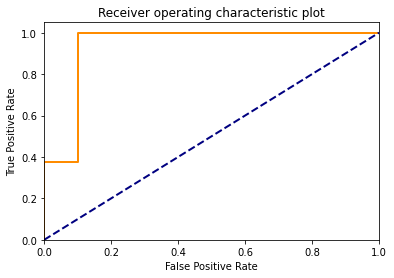

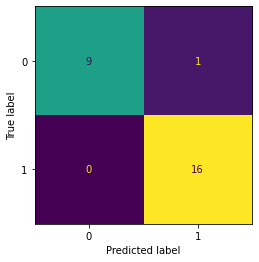

In [837]:
# x. feature selection based on genes in logistic regression with non-zero coefficient

single_gene = df.loc[:, intersection_list]

# create new features vector, and split

X_reduced_sg = standardise(single_gene)
X_train_sg, X_test_sg, y_train_sg, y_test_sg = train_test_split(X_reduced_sg, Y, test_size=0.4, random_state=1)

# train
log_reg_cv_s = LogisticRegressionCV(Cs=20, penalty='l1', solver="liblinear", random_state=1)
log_reg_cv_s.fit(X_train_sg, y_train_sg)
print('Optimum L1 regularisation parameter: '+str(log_reg_cv_s.C_))

# predict
y_pred_sg = log_reg_cv_s.predict(X_test_sg)
y_pred_probab_sg = log_reg_cv_s.predict_proba(X_test_sg)

# evaluate
model_analysis(log_reg_cv_s, X_test_sg, y_pred_sg, y_pred_probab_sg, y_test_sg)

# Not used

In [463]:
# testing for normailty using Shapiro Wilk

norm_dict = OrderedDict()
for column in column_names: #[0:5]:
    con_series = data_tpose3[column][0:35]
    shapiro_test = stats.shapiro(con_series)
    norm_dict[column] = shapiro_test.pvalue
    
#norm_dict

In [659]:
# x. feature selection based on genes in logistic regression with non-zero coefficient

gene_index = []
gene_index.append([val[0] for val in gene_coefs_sorted])
df_red1 = df.loc[:, gene_index[0]]


# create new features vector, and split

X_reduced = standardise(df_red1)
X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_reduced, Y, test_size=0.4, random_state=1)

# SVM classifier

svm_clf=SVC(kernel="linear", random_state=1)
svm_clf.fit(X_red_train, y_train)
svm_clf.score(X_red_test, y_test)


,ILMN_1804148,ILMN_1733276,ILMN_1683817,ILMN_1691402,ILMN_1652650,ILMN_2400183,ILMN_2264011,ILMN_1717197,ILMN_1747192,ILMN_1659800,...,ILMN_2082209,ILMN_1786433,ILMN_2087989,ILMN_1775744,ILMN_1762071,ILMN_1677906,ILMN_1789642,ILMN_1660629,ILMN_1669281,ILMN_2363489
Con_001,9.2482,8.2974,8.9179,9.1453,8.2035,8.3242,10.8239,9.3468,7.9025,7.923,...,9.3405,7.7609,7.5719,8.7739,7.4165,10.3523,7.4165,7.8414,7.5438,8.0306
Con_017,9.1308,8.1693,9.1417,8.8694,8.007,8.1921,11.0308,9.5891,7.8209,7.293,...,9.1884,7.8326,7.7396,8.69,7.4233,10.4527,7.6051,7.9381,7.5823,8.0894
Con_021,9.0007,8.1167,9.154,8.2019,7.909,8.195,10.6904,9.6435,7.8912,7.2871,...,8.6219,7.7485,7.8544,8.1969,7.3221,9.2921,7.6426,8.1409,8.0705,8.2665
Con_022b,9.1283,7.9644,8.997,7.9236,7.9545,8.2893,11.2486,8.8398,7.8079,7.3722,...,9.6519,7.8024,7.8428,8.4029,7.4075,9.0954,7.6117,8.1839,8.0715,8.305
Con_028,9.3336,8.2082,9.0675,8.9659,7.8979,8.2616,11.1644,9.6249,7.9401,7.5242,...,9.61,8.0068,7.9339,8.8487,7.4443,10.3253,7.6561,7.9994,7.5062,8.1178


In [525]:
# to view entire dataframe

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(etc...)

In [ ]:

def std_split(examples, labels, split):
    imputer = SimpleImputer(strategy='median')
    examples_imputed = imputer.fit_transform(examples)
    scaler = StandardScaler()
    examples_scaled = scaler.fit_transform(examples_imputed)
    X_train, X_test, y_train, y_test = train_test_split(examples_scaled, labels, test_size=split, random_state=42)
    return X_train, X_test, y_train, y_test